In [1]:
%matplotlib notebook

import time
import gym

import numpy as np
import matplotlib.pyplot as plt

In [2]:
env = gym.make("CartPole-v1")
env.reset()

for step in range(10):
#    env.render()
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
#    time.sleep(0.01)
    
env.close()

C:\Users\pc\anaconda3\envs\my_rl_env\lib\site-packages\gym\utils\passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


In [3]:
observation

array([ 0.09444131,  1.2144629 , -0.19176526, -1.9615043 ], dtype=float32)

In [4]:
def create_bins(num_bins_per_action=10):
    bins_cart_position = np.linspace(-4.8,4.8,num_bins_per_action)
    bins_cart_velocity = np.linspace(-5,5,num_bins_per_action)
    bins_pole_angle = np.linspace(-0.418,0.418, num_bins_per_action)
    bins_pole_angular_velocity = np.linspace(-5,5,num_bins_per_action)
    
    bins = np.array([bins_cart_position,
                    bins_cart_velocity, 
                    bins_pole_angle,
                    bins_pole_angular_velocity])
    
    return bins

In [5]:
NUM_BINS = 10
BINS = create_bins(NUM_BINS)
#np.digitize() #retounrne l'index d'un bins

In [6]:
def discretize_observation(observations, bins):
    binned_observations = []
    for i, observation in enumerate(observations):
        discretized_observation = np.digitize(observation, bins[i])
        binned_observations.append(discretized_observation)
    return tuple(binned_observations) # Important for later indexing

In [7]:
q_table_shape = (NUM_BINS,NUM_BINS,NUM_BINS,NUM_BINS,env.action_space.n)

In [8]:
q_table = np.zeros(q_table_shape)

In [9]:
q_table.shape

(10, 10, 10, 10, 2)

In [10]:
def epsilon_greedy_action_selection(epsilon, q_table, discrete_state):
    '''
    Returns an action for the agent. Note how it uses a random number to decide on
    exploration versus explotation trade-off.
    '''
    random_number = np.random.random()
    
    # EXPLOITATION, USE BEST Q(s,a) Value
    if random_number > epsilon:

        action = np.argmax(q_table[discrete_state])

    # EXPLORATION, USE A RANDOM ACTION
    else:
        # Return a random 0,1,2,3 action
        action = np.random.randint(0, env.action_space.n)

    return action

In [11]:
def compute_next_q_value(old_q_value, reward, next_optimal_q_value):
    
    return old_q_value +  ALPHA * (reward + GAMMA * next_optimal_q_value - old_q_value)

In [12]:
EPOCHS = 20000
ALPHA = 0.8
GAMMA = 0.9

In [13]:
# Exploration vs. Exploitation parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.001             # Exponential decay rate for exploration prob

In [14]:
BURN_IN = 1
epsilon = 1

EPSILON_END= 10000
EPSILON_REDUCE = 0.0001

In [15]:
def reduce_epsilon(epsilon, epoch):
    if BURN_IN <= epoch <= EPSILON_END:
        epsilon-= EPSILON_REDUCE
    return epsilon

In [16]:
def fail(done, points, reward):
    if done and points < 150:
        reward = -200
    return reward

<IPython.core.display.Javascript object>


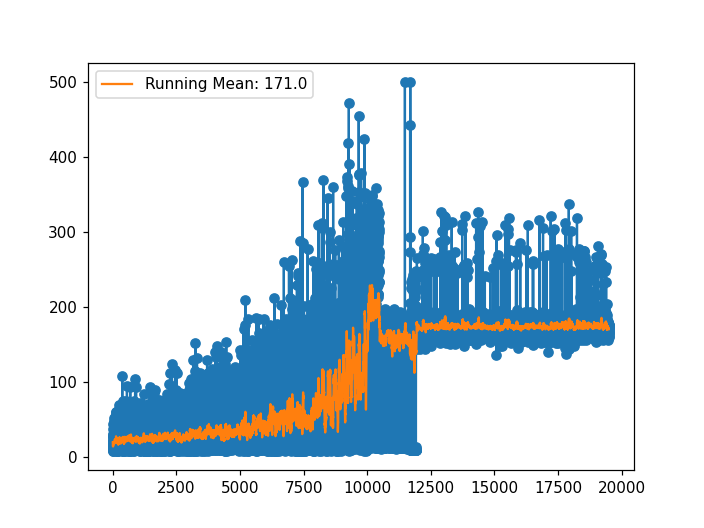

In [17]:
##############################################
### VISUALIZATION OF TRAINING PROGRESS ######
#############################################


log_interval = 500  # How often do we update the plot? (Just for performance reasons)
render_interval = 2000  # How often to render the game during training (If you want to watch your model learning)
### Here we set up the routine for the live plotting of the achieved points ######
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()
##############################################
#############################################

points_log = []  # to store all achieved points
mean_points_log = []  # to store a running mean of the last 30 results
epochs = []  # store the epoch for plotting

for epoch in range(EPOCHS):
    
    ## Continuous State --> Discrete State
    
    initial_state = env.reset()  # get the initial observation
    discretized_state = discretize_observation(initial_state, BINS)  # map the observation to the bins
    
    done = False  # to stop current run when cartpole falls down   
    points = 0  # store result
    
    # Track Epochs for Plotting Visualization
    epochs.append(epoch)
    
    
    while not done:  # Perform current run as long as done is False (as long as the cartpole is up)
        
        # View how the cartpole is doing every render interval
#         if epoch % render_interval == 0:  
#             env.render()

        action = epsilon_greedy_action_selection(epsilon, q_table, discretized_state)  # Epsilon-Greedy Action Selection 
        next_state, reward, done, info = env.step(action)  # perform action and get next state
        reward = fail(done, points, reward)  # Check if reward or fail state


        next_state_discretized = discretize_observation(next_state, BINS)  # map the next observation to the bins

        old_q_value =  q_table[discretized_state + (action,)]  # get the old Q-Value from the Q-Table
        next_optimal_q_value = np.max(q_table[next_state_discretized])  # Get the next optimal Q-Value
        

        next_q = compute_next_q_value(old_q_value, reward, next_optimal_q_value)  # Compute next Q-Value
        q_table[discretized_state + (action,)] = next_q  # Insert next Q-Value into the table

        discretized_state = next_state_discretized  # Update the old state
        points += 1

    epsilon = reduce_epsilon(epsilon, epoch)  # Reduce epsilon
    points_log.append(points)  # log overall achieved points for the current epoch
    running_mean = round(np.mean(points_log[-30:]), 2)  # Compute running mean points over the last 30 epochs
    mean_points_log.append(running_mean)  # and log it
    
    ################ Plot the points and running mean ##################
    if epoch % log_interval == 0:
        ax.clear()
        ax.scatter(epochs, points_log)
        ax.plot(epochs, points_log)
        ax.plot(epochs, mean_points_log, label=f"Running Mean: {running_mean}")
        plt.legend()
        fig.canvas.draw()
  ######################################################################

env.close()


In [21]:
observation = env.reset()
rewards = 0

for step in range(1000):
    env.render()
    discrete_state = discretize_observation(observation, BINS)
    action = np.argmax(q_table[discrete_state])
    observation, reward, done, info = env.step(action)
    rewards += 1
    
    if done:
        print("Rewards : "+ str(rewards))
        break
        
env.close()

error: display Surface quit

In [18]:
#demo_bin = [0,2,4,8,10]
#demo_data = 9
#np.digitize(demo_data, demo_bin)